# Data Analysis for Covid-19 Numbers
***Disclamer: I'm not a epidemiologist, I'm just someone who studies biology and has done a little bit about this kind of thing. Also given that this isn't about total scientific rigor some of the stuff you're about to witness may hurt (sorry statisticians)***

Using data downloaded from [EU Open Data Portal](https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data)  
This project is enables viewing the current state of Covid-19 and aims to perform some basic projections into the future

## Setup
First we need to setup all the imports that we will need:
 - Numpy and pandas provide core data manipulations functionality
 - Matplotlib provides the graphing capability
 - Scipy has many useful things but for this we need `curve_fit(...)`
 - Sympy is used to provide the derivative of the logisitic curve (without having to do the maths myself), so we can convert total cases/deaths to per day with out fitting

In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import sympy as sym
import scipy.optimize as optimize

## Download data and setup Dataframe
Conviently the EU open data site provides url allowing us to directly pull the covid-19 cases and deaths data across the world (this is seperated by country)
Pandas can directly take the URL to pull this CSV

One thing not provided is the cumulative cases/deaths, which can be easily calculated and is necessary for proper curve fitting 

In [2]:
# Download latest data
# Then create a dataframe from it (w/ dataRep as a DateTime object)
# Then we want a relative time representation (just out of usefulness) in days
dataUrl = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
dataset = pd.read_csv(
    dataUrl,
    parse_dates=["dateRep"],
    dayfirst=True
)
dataset["days_since"] = pd.to_timedelta(dataset["dateRep"] - dataset["dateRep"].min(), 'd')

# Rearrange the Dataframe, such that it now has geoId and days_since as
# a MultiIndex
dataset = dataset.set_index(['geoId', 'days_since']).drop(columns=[
   "day", "month", "year",
    "countryterritoryCode"
])
# Finally work out the cumulative cases/deaths for each country
dataset["cum_cases"]  = dataset.sort_index().groupby(level="geoId")['cases'].cumsum()
dataset["cum_deaths"] = dataset.sort_index().groupby(level="geoId")['deaths'].cumsum()

Below is the data which we managed to pull:

In [3]:
dataset

dateRep  cases  deaths countriesAndTerritories  \
geoId days_since                                                     
AF    106 days   2020-04-15     49       2             Afghanistan   
      105 days   2020-04-14     58       3             Afghanistan   
      104 days   2020-04-13     52       0             Afghanistan   
      103 days   2020-04-12     34       3             Afghanistan   
      102 days   2020-04-11     37       0             Afghanistan   
...                     ...    ...     ...                     ...   
ZW    85 days    2020-03-25      0       0                Zimbabwe   
      84 days    2020-03-24      0       1                Zimbabwe   
      83 days    2020-03-23      0       0                Zimbabwe   
      82 days    2020-03-22      1       0                Zimbabwe   
      81 days    2020-03-21      1       0                Zimbabwe   

                  popData2018  cum_cases  cum_deaths  
geoId days_since                                      
AF    106 days     37172386.0        714          23  
      105 days     37172386.0        665          21  
      104 days     37172386.0        607          18  
      103 days     37172386.0        555          18  
      102 days     37172386.0        521          15  
...                       ...        ...         ...  
ZW    85 days      14439018.0          2           1  
      84 days      14439018.0          2           1  
      83 days      14439018.0          2           0  
      82 days      14439018.0          2           0  
      81 days      14439018.0          1           0  

[10947 rows x 7 columns]

Below is the list of countries for which data can be pulled:

In [4]:
dataset["countriesAndTerritories"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua_and_Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius and Saba', 'Bosnia_and_Herzegovina',
       'Botswana', 'Brazil', 'British_Virgin_Islands',
       'Brunei_Darussalam', 'Bulgaria', 'Burkina_Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Cape_Verde',
       'Cases_on_an_international_conveyance_Japan', 'Cayman_Islands',
       'Central_African_Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo', 'Costa_Rica', 'Cote_dIvoire', 'Croatia', 'Cuba',
       'Curaçao', 'Cyprus', 'Czechia', 'Democratic_Republic_of_the_Congo',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican_Republic', 'Ecuador',
       'Egypt', 'El_Salvador', 'Equatorial_Guinea', 'Eritrea', 'Estonia',


# Data Fitting
***Note: All the numbers from here on out are done for the UK, given that I'm a UK citizen it made sense to just look at that slice, as having everything would just be too much to parse (but not for the computer).  
If you want to see the data for your own country look up the geoId in the dataset that corrosponds to your country and replace `'UK'` with it***

For population growth which is limited by resources it can be described by a logisitic function (equation 1). Using `scipy.optimize.curve_fit(...)` we can fit the data we have to a 4-parameter logistic function (equation 2), so that we have the paramater values necessary to plot our fit and make some basic predictions.

$$
\begin{align}
    \frac{dN}{dt} &= r N \left(1 - \frac{N}{\kappa}\right) &&\quad (1) \\
    N &= d + \frac{a - d}{1 + \left(\frac{N}{\kappa}\right)^2} &&\quad (2)
\end{align}
$$


In [5]:
x, a, b, c, d = sym.symbols('x a b c d')

logistic_map       = d + (a - d)/(1 + (x/c)**b)
logistic_map_deriv = sym.diff(logistic_map, x)

def logistic(X, A, B, C, D):       return sym.lambdify([x, a, b, c, d], logistic_map,       'numpy')(X, A, B, C, D)
def logistic_deriv(X, A, B, C, D): return sym.lambdify([x, a, b, c, d], logistic_map_deriv, 'numpy')(X, A, B, C, D)

# The initial guesses are based on the results of previous fitting attempts. These ensure
# that an future attempts at fitting still result in a similar curve when the data is updated.
#
# n.b. The data here is fit the cumulative cases/deaths, as the logistic function in the
#      context of ecology is w.r.t. total population size (aka cumulative population)
#
params_death, cov_death = optimize.curve_fit(logistic, dataset.loc["UK"].index.days, dataset.loc["UK"]["cum_deaths"],p0=[1, 20, 100, 2e4])
params_cases, cov_cases = optimize.curve_fit(logistic, dataset.loc["UK"].index.days, dataset.loc["UK"]["cum_cases"], p0=[1, 30, 100, 2e4])

## Graph Plotting
Finally we get to the good part!
### Cummulative Cases & Deaths
Below is the graph for the raw cummulative number of deaths/cases of covid-19 plotted along with the curve of best fit and our estimates of the 95% confidence interval

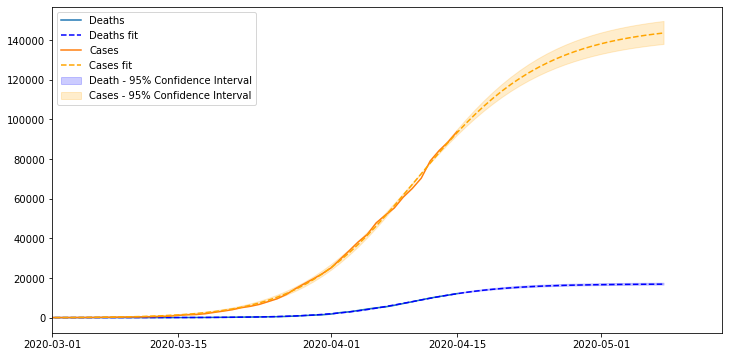

In [6]:
fig, ax = plt.subplots(figsize=(12,6))

# 130 days since day 0 felt like long enough
dt = pd.to_timedelta(np.arange(0, 130), 'D')

# Death plot
ax.plot(dataset.loc["UK"]["dateRep"], dataset.loc["UK"]["cum_deaths"], label="Deaths")
ax.plot(dt + dataset.loc["UK"]["dateRep"].min(), logistic(dt.days, *params_death), "--", label="Deaths fit", color="blue")
ax.fill_between(dt + dataset.loc["UK"]["dateRep"].min(), logistic(dt.days, *(params_death + 2*np.sqrt(np.diag(cov_death)))),
                    logistic(dt.days, *(params_death - 2*np.sqrt(np.diag(cov_death)))),
                    alpha=0.2, color="blue", label="Death - 95% Confidence Interval"
               )
# Cases plot
ax.plot(dataset.loc["UK"]["dateRep"], dataset.loc["UK"]["cum_cases"], label="Cases")
ax.plot(dt + dataset.loc["UK"]["dateRep"].min(), logistic(dt.days, *params_cases), "--",  label="Cases fit", color="orange")
ax.fill_between(dt + dataset.loc["UK"]["dateRep"].min(), logistic(dt.days, *(params_cases + 2*np.sqrt(np.diag(cov_cases)))),
                    logistic(dt.days, *(params_cases - 2*np.sqrt(np.diag(cov_cases)))),
                    alpha=0.2, color="orange", label="Cases - 95% Confidence Interval"
               )

# This is arbitrarily set to give a decent overview of the UK data
ax.set_xlim(pd.Timestamp("2020-03"), None)
ax.legend()

### Per Day Rate of Cases & Deaths
Similar to the last graph, but uses the derivative of the 4-paramater logistic equation with the same paramaters from `curve_fit(...)` to fit to the daily numbers rather than the
total numbers

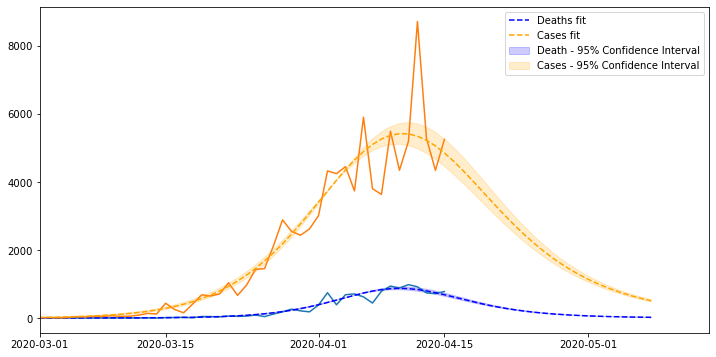

In [7]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(dataset.loc["UK"]["dateRep"], dataset.loc["UK"]["deaths"])
ax.plot(dt + dataset.loc["UK"]["dateRep"].min(), logistic_deriv(dt.days, *params_death), "--", label="Deaths fit", color="blue")
ax.fill_between(dt+ dataset.loc["UK"]["dateRep"].min(),
                logistic_deriv(dt.days, *(params_death + 2*np.sqrt(np.diag(cov_death)))),
                logistic_deriv(dt.days, *(params_death - 2*np.sqrt(np.diag(cov_death)))),
                alpha=0.2, color="blue", label="Death - 95% Confidence Interval"
               )

ax.plot(dataset.loc["UK"]["dateRep"], dataset.loc["UK"]["cases"])
ax.plot(dt + dataset.loc["UK"]["dateRep"].min(), logistic_deriv(dt.days, *params_cases), "--",  label="Cases fit", color="orange")
ax.fill_between(dt + dataset.loc["UK"]["dateRep"].min(), 
                logistic_deriv(dt.days, *(params_cases + 2*np.sqrt(np.diag(cov_cases)))),
                logistic_deriv(dt.days, *(params_cases - 2*np.sqrt(np.diag(cov_cases)))),
                alpha=0.2, color="orange", label="Cases - 95% Confidence Interval"
               )

ax.set_xlim(pd.Timestamp("2020-03"), None)
ax.legend()

### Total cases against New Cases
***admittedly this is stolen from MinutePhysics who did this better, but still I wanted to give it a go***

Given that the rate of infection is dependent on the size of the infected population,
plotting how many new infected against currently infected can produce a useful linear graph, because:

$$\lim_{N \rightarrow 0} \left(r N \left(1 - \frac{N}{\kappa}\right)\right) = r N $$ 

This of course changes as $N \rightarrow \kappa \because \frac{N}{\kappa} \rightarrow 1$, thus we end up with the $\frac{dN}{dt} \rightarrow 0$. As such we would expect the plot to be linear until infection gets too big and can't find enough people to keep growing exponentially.

Given that the sizes of the populations involved are quite large, I used log scales as it quite usefully scale the graph

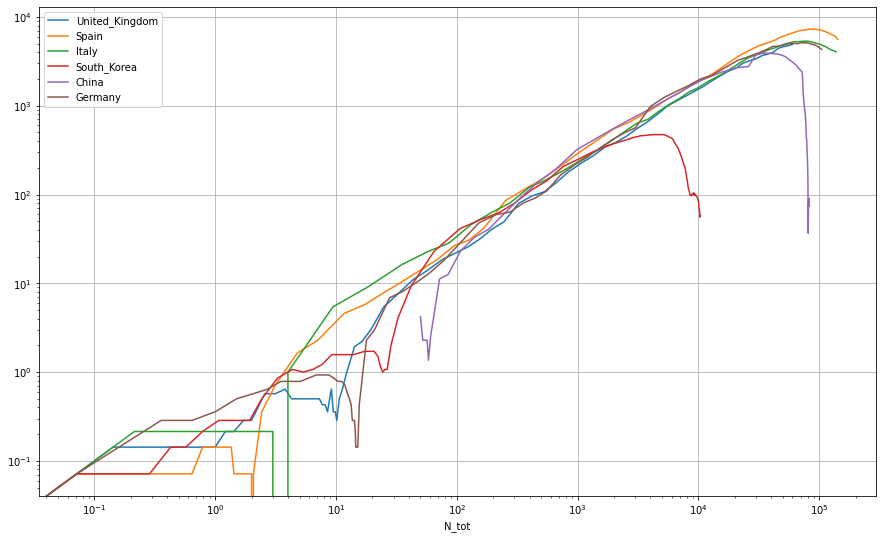

In [9]:
fig, ax = plt.subplots(figsize=(15,9))


# Lets plot a few other notable countries for comparision
for geoId in ["UK",
              "ES", "IT",
              "KR", "CN",
              "DE"
             ]:
    paired = pd.DataFrame({
        "N":     dataset.loc[geoId]["cases"],
        "N_tot": dataset.loc[geoId]["cum_cases"]
    })
    paired.rolling(window=14).mean().plot("N_tot", "N",ax=ax, label=dataset.loc[geoId]["countriesAndTerritories"].unique()[0])

# To switch to linear scales to comment out the following two lines:
ax.set_yscale('log')
ax.set_xscale('log')

ax.grid()